In [1]:
library(harmony)
library(dplyr)
library(Matrix)
library(mgcv)
library(data.table)
library(igraph)
# library(pheatmap)
library(mclust)
library(Seurat)
library(cluster)
library(pdfCluster)
library(reticulate)
library(viridis)
library(RColorBrewer)
library(umap)
library(pacman)
p_load(pheatmap, ggdendro)
options(scipen = 4)
options(repr.plot.width=14, repr.plot.height=13)

Loading required package: Rcpp


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.8-33. For overview type 'help("mgcv-package")'.


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Package 'mclust' version 5.4.7
Type 'citation("mclust")' for citing this R package in publications.


Attaching package: ‘mclust’


The following object is masked from ‘package:mgcv’:

 

In [ ]:
# p_load(devtools)
# install_github("immunogenomics/harmony")


In [2]:
chrs = fread("/u/s/s/sshen82/Rfile/Hi-C/hg19.chrom.sizes") %>% filter(V1 %in% paste0("chr", c(1:22, "X")))

In [3]:

chrs$V2 = ceiling(chrs$V2 / 1000000)

chr_order = paste("chr", c(1:22, "X"), sep = "")
chrsize = chrs[match(chr_order, chrs$V1), ]$V2

cols = c("dodgerblue2", "#E31A1C", "green4", "#6A3D9A", "#FF7F00",
         "black", "gold1", "skyblue2", "palegreen2", "#FDBF6F",
         "gray70", "maroon", "orchid1", "darkturquoise")

names(cols) = c("Astro", "Endo", "L23", "L4", 'L5', 'L6', 'MG', 'MP', 'Ndnf',
                           'ODC', 'OPC', 'Pvalb', 'Sst', 'Vip')



quantile_breaks <- function(xs, n = 10) {
  breaks <- quantile(xs[xs != 0], probs = seq(0, 1, length.out = (n - 1)))
  c(0, breaks[!duplicated(breaks)])
}


In [4]:
# path = "/p/keles/schic/volumeA/Ecker2019/human/Counts_1mb_schic/"
# setwd(path)
# cell_types = list.files()
# cell_type_folders = list.files()
# cell_type_folders = paste(path, cell_type_folders, sep = "")
# num_types = length(cell_type_folders)

# cell_folders = c()
# clusters = c()
# cell_names = c()
# for (i in 1:num_types){
#   path = list.files(cell_type_folders[i])
#   cell_names = c(cell_names, path)
#   path = paste(cell_type_folders[i], "/", path, sep = "")
#   cell_folders = c(cell_folders, path)
#   clusters = c(clusters, rep(cell_types[i], length(path)))
# }

# #This if condition is just to check if you choose Ren's data or Ecker's.
# num_chrs = 24
# num_cells = 2611
# chr_order = c("1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13",
#               "14", "15", "16", "17", "18", "19", "20", "21", "22", "X", "Y")
# chrs = paste("chr", chr_order, sep = "")

# summary = fread("/p/keles/schic/volumeA/Ecker2019/human/Ecker2019_summary.txt")
# summary = summary[match(cell_names, summary$name), ]
# cell_type = data.frame(Cell_Types = as.factor(summary$cell_type))
# depth = data.frame(Depth = log(summary$depth))

# rownames(cell_type) = cell_names
# rownames(depth) = cell_names


In [5]:
mlgFindNeighbors = function(latent){
  rownames(latent) = paste0("cell", 1:nrow(latent))
  NN_graph = FindNeighbors(latent, verbose = FALSE, k.param = 150, prune.SNN = 1/10)
  G = NN_graph$snn
  return(G)
}
mlgARI = function(G, clusterN, cluster){
  l = 0.1
  h = 2
  iter = 1
  while (l < h) {
    mid = l + (h - l) / 2
    mlgc = try(FindClusters(G, resolution = mid, random.seed = 2020, verbose = FALSE)[[1]])
    if(class(mlgc) == "try-error"){
      h = mid
    }else{
      nml = length(unique(mlgc))
      if (nml == clusterN) break
      if (iter > 20) {
        print("not arrive")
        break
      }
      if (nml < clusterN) l = mid
      else h = mid 
    }
    iter = iter + 1
  }
  mlgARI = adj.rand.index(mlgc, cluster)
  return(mlgARI)
}

In [6]:
# #Loading cells
# band_raw = list()
# j = 1
# for (i in 1:23){
#     temp = chrsize[i] - 1
#     for (k in 1:3){
#         band_raw[[j]] = matrix(0, nrow = num_cells, ncol = temp)
#         temp = temp - 1
#         j = j + 1
#     }
# }
# band_iceoe = band_raw

# print("Step 1")
# for (j in 1:2611){
#     hic_file = fread(cell_folders[j])
#     p = 1
#     for (i in 1:23){
#         hic = hic_file[hic_file$V1 == chr_order[i], ]
#         sc_hic = sparseMatrix(i = hic$V2 / 1000000, j = hic$V4 / 1000000, x = hic$V5, 
#                         dims = c(chrsize[i], chrsize[i]), index1 = FALSE)
#         sc_hic = as.matrix(sc_hic)
#         for (k in 2:4){
#             band_raw[[p]][j, ] = sc_hic[col(sc_hic) - row(sc_hic) == (k - 1)]
#             p = p + 1
#         }
#     }
# }

# print("Step 2")
# for (i in 1:length(band_iceoe)){
#     bandDepth = rowSums(band_raw[[i]])
#     a = bandDepth * mean(bandDepth)
#     a[a == 0] = 1
#     band_iceoe[[i]] = band_raw[[i]] / a
# }


In [7]:
# G = mlgFindNeighbors(band_raw[[1]])
# for (i in 2:length(band_raw)){
#   G = G + mlgFindNeighbors(band_raw[[i]])
# }
# G = as.matrix(G)
# G = G / length(band_raw)
# rownames(G) = cell_names
# colnames(G) = cell_names
# pheatmap(G, cluster_rows = FALSE, cluster_cols = FALSE, show_rownames = FALSE, show_colnames = FALSE, 
#          annotation_row = cell_type, annotation_col = depth)

In [8]:
# G = mlgFindNeighbors(band_iceoe[[1]])
# for (i in 2:length(band_iceoe)){
#   G = G + mlgFindNeighbors(band_iceoe[[i]])
# }
# G = as.matrix(G)
# G = G / length(band_raw)
# rownames(G) = cell_names
# colnames(G) = cell_names
# pheatmap(G, cluster_rows = FALSE, cluster_cols = FALSE, show_rownames = FALSE, show_colnames = FALSE, 
#          annotation_row = cell_type, annotation_col = depth)

In [9]:
hclustCheck = function(G){
    cellTypeList = c("Astro", "Endo", "L23", "L4", 'L5', 'L6', 'MG', 'MP', 'Ndnf', 'ODC', 'OPC', 'Pvalb', 'Sst', 'Vip')
    corM <- matrix(0, nrow = length(cellTypeList), ncol = length(cellTypeList))
    for(c1 in 1:length(cellTypeList)){
        for(c2 in c1:length(cellTypeList)){
            rowI <- which(gsub(".txt", "", gsub(".*\\_", "", rownames(G))) == cellTypeList[c1])
            colI <- which(gsub(".txt", "", gsub(".*\\_", "", colnames(G))) == cellTypeList[c2])

            corV <- mean(G[rowI, colI])
            corM[c1, c2] <- corV
            corM[c2, c1] <- corV
        }
    }
    corM <- max(corM) - corM
    colnames(corM) <- cellTypeList
    rownames(corM) <- cellTypeList

    hc <- hclust(as.dist(corM))
    return(hc)

}

In [10]:
snn_step1 = function(methodName, embeddings, ecker_order, sums){
    
    G = mlgFindNeighbors(as.matrix(embeddings[, 1:min(150, ncol(embeddings))]))
    G = as.matrix(G)
    diag(G) = 0
    mat_breaks <- quantile_breaks(G, n = 30)
    sums = sums[match(ecker_order, sums$name), ]
    depth = data.frame(logDepth = log(sums$depth), batch = sums$batch)
    sums$cell_type = factor(sums$cell_type, levels = c("Astro", "Endo", "L23", "L4", 'L5', 'L6', 'MG', 'MP', 'Ndnf', 'ODC', 'OPC', 'Pvalb', 'Sst', 'Vip'), 
                        labels =  c("Astro", "Endo", "L2/3", "L4", 'L5', 'L6', 'MG', 'MP', 'Ndnf', 'ODC', 'OPC', 'Pvalb', 'Sst', 'Vip'))

    cellTypeList = c("Astro", "Endo", "L2/3", "L4", 'L5', 'L6', 'MG', 'MP', 'Ndnf', 'ODC', 'OPC', 'Pvalb', 'Sst', 'Vip')
    cols = c("dodgerblue2", "#E31A1C", "green4", "#6A3D9A", "#FF7F00", "black", "gold1", "skyblue2", "palegreen2", "#FDBF6F", "gray70", "maroon", "orchid1", "darkturquoise")
    names(cols) = cellTypeList

    cell_type = data.frame(Cell_Type = sums$cell_type, Cell_Batch = sums$batch)
    rownames(cell_type) = ecker_order
    cell_type2 = data.frame(CellBatch = sums$batch, CellType = sums$cell_type)
    rownames(cell_type2) = ecker_order

    batchCols = plasma(5)
    names(batchCols) = unique(cell_type$Cell_Batch)

    rownames(G) = ecker_order
    colnames(G) = ecker_order

    pheatmap(G, cluster_rows = FALSE, breaks = mat_breaks, color = c("white", viridis(length(mat_breaks) - 1, begin = 0.1, direction = -1)), cluster_cols = FALSE, 
             annotation_colors = list(Cell_Batch = batchCols, Cell_Type = cols, CellBatch = batchCols, CellType = cols), annotation_row = cell_type, annotation_col = cell_type2, 
             annotation_names_row = FALSE, show_rownames = FALSE, show_colnames = FALSE, filename = paste0("/p/keles/schic/volumeA/Figures/", methodName, "_SNN.png"))

    pdf(paste0("/p/keles/schic/volumeC/SiqiShen/code/BandNormPaper/Figures/", methodName, "_hclust.pdf"))
    print(ggdendrogram(hclustCheck(G), rotate = FALSE, size = 2))
    dev.off()
    
}



# ecker_order = fread("/p/keles/schic/volumeA/Ecker2019/human/cell_order_iceoe.csv")[-1, -1]$V2
# sums = fread("/p/keles/schic/volumeA/Ecker2019/human/Ecker2019_summary.txt")
# embeddings = fread("/p/keles/schic/volumeA/Ecker2019/human/ecker_tsne_base/ecker_raw.csv")


snn_step2 = function(methodName, embeddings, ecker_order, sums, cT, cL, cI){
    sums = sums[match(ecker_order, sums$name), ]
    depth = data.frame(logDepth = log(sums$depth), batch = sums$batch)
    sums$cell_type = factor(sums$cell_type, levels = cT, labels = cL)

    cellTypeList = c("Astro", "Endo", "L2/3", "L4", 'L5', 'L6', 'MG', 'MP', 'Ndnf', 'ODC', 'OPC', 'Pvalb', 'Sst', 'Vip')
    cols = c("dodgerblue2", "#E31A1C", "green4", "#6A3D9A", "#FF7F00", "black", "gold1", "skyblue2", "palegreen2", "#FDBF6F", "gray70", "maroon", "orchid1", "darkturquoise")
    names(cols) = cellTypeList
    cols = cols[cI]

    cell_type = data.frame(Cell_Type = sums$cell_type, Cell_Batch = sums$batch)
    rownames(cell_type) = ecker_order
    cell_type2 = data.frame(CellBatch = sums$batch, CellType = sums$cell_type)
    rownames(cell_type2) = ecker_order
    batchCols = plasma(5)
    names(batchCols) = unique(cell_type$Cell_Batch)

    cellOrder = order(sums$cell_type, sums$batch)
    G = mlgFindNeighbors(as.matrix(embeddings[cellOrder, 1:min(150, ncol(embeddings))]))
    G = as.matrix(G)
    diag(G) = 0
    mat_breaks <- quantile_breaks(G, n = 30)

    rownames(G) = ecker_order[cellOrder]
    colnames(G) = ecker_order[cellOrder]

    pheatmap(G, cluster_rows = FALSE, breaks = mat_breaks, color = c("white", viridis(length(mat_breaks) - 1, begin = 0.1, direction = -1)), cluster_cols = FALSE, 
             annotation_colors = list(Cell_Batch = batchCols, Cell_Type = cols, CellBatch = batchCols, CellType = cols), annotation_row = cell_type, annotation_col = cell_type2, 
             annotation_names_row = FALSE, show_rownames = FALSE, show_colnames = FALSE, filename = paste0("/p/keles/schic/volumeC/SiqiShen/code/BandNormPaper/Figures/", methodName, "_SNN_cluster.png"))

}


In [11]:
methodName = "CellScale"
embeddings = fread("/p/keles/schic/volumeC/SiqiShen/code/BandNormPaper/paper_prep/01072022/embeddings/Lee2019_CellScaleHARMONY.csv")
sums = fread("/p/keles/schic/volumeC/SiqiShen/code/BandNormPaper/paper_prep/01072022/summaryFiles/Lee2019_summary.txt")
ecker_order = sums$name

snn_step1(methodName, embeddings, ecker_order, sums)
cT = c("L4", "L5", "L6", "L23", "Ndnf", "Vip", "Pvalb", "Sst", "MG", "MP", "Endo", "ODC", "Astro", "OPC")
cL = c("L4", "L5", "L6", "L2/3", "Ndnf", "Vip", "Pvalb", "Sst", "MG", "MP", "Endo", "ODC", "Astro", "OPC")
cI = c(4, 5, 6, 3, 9, 14, 12, 13, 7, 8, 2, 10, 1, 11)

snn_step2(methodName, embeddings, ecker_order, sums, cT, cL, cI)


pdf 
  3

In [12]:
methodName = "BandScale"
embeddings = fread("/p/keles/schic/volumeC/SiqiShen/code/BandNormPaper/paper_prep/01072022/embeddings/Lee2019_BandScaleHARMONY.csv")
sums = fread("/p/keles/schic/volumeC/SiqiShen/code/BandNormPaper/paper_prep/01072022/summaryFiles/Lee2019_summary.txt")
ecker_order = sums$name

snn_step1(methodName, embeddings, ecker_order, sums)
cT = c("L4", "L23",  "Ndnf", "Vip", "Pvalb", "Sst", "L5", "L6", "MG", "MP", "ODC", "Endo", "Astro", "OPC")
cL = c("L4", "L2/3", "Ndnf", "Vip", "Pvalb", "Sst", "L5", "L6", "MG", "MP", "ODC", "Endo", "Astro", "OPC")
cI = c(4, 3,  9, 14, 12, 13, 5, 6, 7, 8, 10, 2, 1, 11)
snn_step2(methodName, embeddings, ecker_order, sums, cT, cL, cI)




pdf 
  3

In [13]:
methodName = "BandNorm_noBatchRM"
embeddings = fread("/p/keles/schic/volumeA/Script/SNN_heatmap/data/ecker.csv")
ecker_order = fread("/p/keles/schic/volumeA/Ecker2019/human/cell_order_iceoe.csv")[-1, -1]$V2
sums = fread("/p/keles/schic/volumeA/Ecker2019/human/Ecker2019_summary.txt")

snn_step1(methodName, embeddings, ecker_order, sums)
cT = c("L4", "L5", "L6", "L23", "Ndnf", "Vip", "Pvalb", "Sst", "MG", "MP", "ODC",  "OPC", "Astro", "Endo")
cL = c("L4", "L5", "L6", "L2/3",  "Ndnf", "Vip", "Pvalb", "Sst", "MG", "MP", "ODC",  "OPC", "Astro", "Endo")
cI = c(4, 5, 6, 3, 9, 14, 12, 13, 7, 8, 10, 11, 1, 2)
snn_step2(methodName, embeddings, ecker_order, sums, cT, cL, cI)


pdf 
  3

In [14]:
methodName = "BandNorm_harmony"
embeddings = fread("/p/keles/schic/volumeA/Script/SNN_heatmap/data/ecker.csv")
ecker_order = fread("/p/keles/schic/volumeA/Ecker2019/human/cell_order_iceoe.csv")[-1, -1]$V2
sums = fread("/p/keles/schic/volumeA/Ecker2019/human/Ecker2019_summary.txt")

embeddings = as.matrix(embeddings)
sums = sums[match(ecker_order, sums$name), ]
sums$cell_type = as.factor(sums$cell_type)
depth = data.frame(logDepth = log(sums$depth))
my_harmony_embeddings <- HarmonyMatrix(t(embeddings), sums$batch, "dataset", do_pca = FALSE)

snn_step1(methodName, t(my_harmony_embeddings), ecker_order, sums)

cT = c("L4", "L5", "L6", "L23", "Ndnf", "Vip", "Pvalb", "Sst", "MG", "MP", "ODC", "OPC", "Astro", "Endo")
cL = c("L4", "L5", "L6", "L2/3",  "Ndnf", "Vip", "Pvalb", "Sst", "MG", "MP", "ODC", "OPC", "Astro", "Endo")
cI = c(4, 5, 6, 3, 9, 14, 12, 13, 7, 8, 10, 11, 1, 2)
snn_step2(methodName, t(my_harmony_embeddings), ecker_order, sums, cT, cL, cI)


Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations



pdf 
  3

In [15]:
methodName = "scHiCluster"
embeddings = fread("/p/keles/schic/volumeC/SiqiShen/code/BandNormPaper/paper_prep/01072022/embeddings/Lee2019_schicluster.csv")
sums = fread("/p/keles/schic/volumeC/SiqiShen/code/BandNormPaper/paper_prep/01072022/summaryFiles/Lee2019_summary.txt")
ecker_order = sums$name

batch = data.frame(sums)$batch
embeddings <- harmony::HarmonyMatrix(embeddings, batch, "dataset", do_pca = FALSE)

snn_step1(methodName, embeddings, ecker_order, sums)
cT = c("L4", "L5", "L6", "L23", "Ndnf", "Pvalb", "Vip",  "Sst", "Astro", "OPC", "MG", "MP", "ODC", "Endo")
cL = c("L4", "L5", "L6", "L2/3",  "Ndnf",  "Pvalb", "Vip", "Sst", "Astro", "OPC", "MG", "MP", "ODC", "Endo")
cI = c(4, 5, 6, 3, 9,  12, 14, 13, 1, 11, 7, 8, 10, 2)
snn_step2(methodName, embeddings, ecker_order, sums, cT, cL, cI)


Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10



pdf 
  3

In [16]:
methodName = "CNN"
embeddings = fread("/p/keles/schic/volumeC/SiqiShen/code/BandNormPaper/paper_prep/01072022/embeddings/Lee2019_CNNcellscaleHARMONY.csv")
sums = fread("/p/keles/schic/volumeC/SiqiShen/code/BandNormPaper/paper_prep/01072022/summaryFiles/Lee2019_summary.txt")
ecker_order = sums$name

snn_step1(methodName, embeddings, ecker_order, sums) ## "Astro", "Endo", "L2/3", "L4", 'L5', 'L6', 'MG', 'MP', 'Ndnf', 'ODC', 'OPC', 'Pvalb', 'Sst', 'Vip'
cT = c("L4", "L5", "L23", "Pvalb", "L6", "Vip", "Ndnf", "Sst", "Endo", "MG", "MP", "OPC", "Astro", "ODC")
cL = c("L4", "L5", "L2/3", "Pvalb", "L6", "Vip", "Ndnf", "Sst", "Endo", "MG", "MP", "OPC", "Astro", "ODC")
cI = c(4, 5, 3, 12, 6, 14, 9, 13, 2, 7, 8, 11, 1, 10)
snn_step2(methodName, embeddings, ecker_order, sums, cT, cL, cI)


pdf 
  3

In [17]:
methodName = "Higashi"
embeddings = fread("/p/keles/schic/volumeC/SiqiShen/code/BandNormPaper/paper_prep/01072022/embeddings/Lee2019_higashi.csv")
sums = fread("/p/keles/schic/volumeC/SiqiShen/code/BandNormPaper/paper_prep/01072022/summaryFiles/Lee2019_summary.txt")
ecker_order = sums$name

snn_step1(methodName, embeddings, ecker_order, sums)
cT = c("L4", "L5", "L6", "L23", "Ndnf", "Vip", "Pvalb", "Sst", "MG", "MP",  "Endo", "ODC", "Astro", "OPC")
cL = c("L4", "L5", "L6", "L2/3",  "Ndnf",  "Vip", "Pvalb", "Sst", "MG", "MP", "Endo", "ODC",  "Astro", "OPC")
cI = c(4, 5, 6, 3, 9, 14,  12, 13, 7, 8, 2, 10,  1, 11)
snn_step2(methodName, embeddings, ecker_order, sums, cT, cL, cI)


pdf 
  3

In [18]:
methodName = "scHiCtopics"
embeddings = fread("/p/keles/schic/volumeA/Script/SNN_heatmap/data/ecker_cis.csv")[, -1]
embeddings = as.matrix(prcomp(embeddings)$x)
ecker_order = fread("/p/keles/schic/volumeA/Script/SNN_heatmap/data/ecker_order.csv")[-1, -1]$V2
sums = fread("/p/keles/schic/volumeA/Ecker2019/human/Ecker2019_summary.txt")

batch = data.frame(sums)$batch
embeddings <- harmony::HarmonyMatrix(embeddings, batch, "dataset", do_pca = FALSE)

## snn_step1(methodName, embeddings, ecker_order, sums)
cT = c("L5", "L6", "L23", "L4", "Sst",  "Pvalb",  "Ndnf", "Vip",  "Endo", "MG", "MP", "ODC",  "OPC", "Astro")
cL = c("L5","L6", "L2/3", "L4", "Sst",  "Pvalb",  "Ndnf", "Vip", "Endo", "MG", "MP", "ODC", "OPC",  "Astro")
cI = c( 5, 6, 3, 4, 13, 12,  9, 14, 2, 7, 8, 10, 11, 1)
snn_step2(methodName, embeddings, ecker_order, sums, cT, cL, cI)


Harmony 1/10

Harmony 2/10

Harmony converged after 2 iterations



In [38]:
##Higashi normCount

pcaMPC <- readRDS(file = "/p/keles/schic/volumeC/YeZheng_workingDirectory/results/Ecker2019/RDS/Higashi_normCount_full.rds")

cols = c("dodgerblue2", "#E31A1C", "green4", "#6A3D9A", "#FF7F00",
         "black", "gold1", "skyblue2", "palegreen2", "#FDBF6F",
         "gray70", "maroon", "orchid1", "darkturquoise")

cellTypeList = c("Astro", "Endo", "L23", "L4", 'L5', 'L6', 'MG', 'MP', 'Ndnf', 'ODC', 'OPC', 'Pvalb', 'Sst', 'Vip')
names(cols) = cellTypeList
                           
mlgFindNeighbors = function(latent){
  rownames(latent) = paste0("cell", 1:nrow(latent))
  NN_graph = FindNeighbors(latent, verbose = FALSE, k.param = 150, prune.SNN = 1/10)
  G = NN_graph$snn
  return(G)
}
cellSum <- fread("/p/keles/schic/volumeA/Ecker2019/human/Ecker2019_summary.txt")
colnames(cellSum)[3] <- "cluster"
colnames(cellSum)[1] <- "cell"
cellOrder = order(cellSum$cluster, cellSum$batch)

G = mlgFindNeighbors(as.matrix(pcaMPC[cellOrder, 1:150]))
G = as.matrix(G)
diag(G) = 0
mat_breaks <- quantile_breaks(G, n = 30)
cell_type <- data.frame(Cell_Batch = cellSum$batch[cellOrder], Cell_Type = factor(cellSum$cluster[cellOrder]))
rownames(cell_type) <- cellSum$cell[cellOrder]
cell_type2 <- data.frame(CellType = factor(cellSum$cluster[cellOrder]), CellBatch = cellSum$batch[cellOrder])
rownames(cell_type2) <- cellSum$cell[cellOrder]
## cell_depth <- data.frame(logDepth = log(cellSum$seqDepthSum[cellOrder]))
## rownames(cell_depth) <- cellSum$cell[cellOrder]
rownames(G) <- cellSum$cell[cellOrder]
colnames(G) <- cellSum$cell[cellOrder]
batchCols = plasma(5)
names(batchCols) = unique(cell_type$Cell_Batch)

 pheatmap(G, cluster_rows = FALSE, breaks = mat_breaks, color = c("white", viridis(length(mat_breaks) - 1, begin = 0.1, direction = -1)), cluster_cols = FALSE, 
             annotation_colors = list(Cell_Batch = batchCols, Cell_Type = cols, CellBatch = batchCols, CellType = cols), annotation_row = cell_type, annotation_col = cell_type2, 
             annotation_names_row = FALSE, show_rownames = FALSE, show_colnames = FALSE, filename = "/p/keles/schic/volumeA/Figures/Ecker2019_Higashi_normCount_SNN.png")

In [39]:
## hclust
cellTypeList = c("Astro", "Endo", "L23", "L4", 'L5', 'L6', 'MG', 'MP', 'Ndnf', 'ODC', 'OPC', 'Pvalb', 'Sst', 'Vip')
corM <- matrix(0, nrow = length(cellTypeList), ncol = length(cellTypeList))
for(c1 in 1:length(cellTypeList)){
    for(c2 in c1:length(cellTypeList)){
        rowI <- which(gsub(".*\\_", "", rownames(G)) == paste0(cellTypeList[c1], ".txt"))
        colI <- which(gsub(".*\\_", "", colnames(G)) == paste0(cellTypeList[c2], ".txt"))

        corV <- mean(G[rowI, colI])
        corM[c1, c2] <- corV
        corM[c2, c1] <- corV
    }
}

corM <- max(corM) - corM
colnames(corM) <- cellTypeList
rownames(corM) <- cellTypeList

hc <- hclust(as.dist(corM))

pdf("/p/keles/schic/volumeA/Figures/Ecker2019_Higashi_norCount_hclust.pdf")
ggdendrogram(hc, rotate = FALSE, size = 2)
dev.off()

png 
  2

In [40]:
cellSum <- fread("/p/keles/schic/volumeA/Ecker2019/human/Ecker2019_summary.txt")
colnames(cellSum)[3] <- "cluster"
colnames(cellSum)[1] <- "cell"
cellTypeHC <- c("L4", "L23", "L5", "L6", "Ndnf", "Vip", "Sst", "Pvalb", "Astro", "OPC", "ODC", "Endo", "MG", "MP")
cellTypeLabel <- c("L4", "L2/3", "L5", "L6",  "Ndnf", "Vip", "Sst", "Pvalb", "Astro", "OPC", "ODC", "Endo", "MG", "MP")
cellSum$cluster <- factor(cellSum$cluster, levels = cellTypeHC, labels = cellTypeLabel)


cols = c("dodgerblue2", "#E31A1C", "green4", "#6A3D9A", "#FF7F00", "black", "gold1", "skyblue2", "palegreen2", "#FDBF6F", "gray70", "maroon", "orchid1", "darkturquoise")
cellTypeList = c("Astro", "Endo", "L2/3", "L4", 'L5', 'L6', 'MG', 'MP', 'Ndnf', 'ODC', 'OPC', 'Pvalb', 'Sst', 'Vip')
names(cols) = cellTypeList
cols <- cols[c(4, 3, 5, 6,   9, 14, 13, 12, 1, 11, 10, 2, 7, 8)]

cellOrder = order(cellSum$cluster, cellSum$batch)

G = mlgFindNeighbors(as.matrix(pcaMPC[cellOrder, 1:150]))
G = as.matrix(G)
diag(G) = 0
mat_breaks <- quantile_breaks(G, n = 30)
cell_type2 <- data.frame(CellBatch = cellSum$batch[cellOrder], CellType = factor(cellSum$cluster[cellOrder]))
rownames(cell_type2) <- cellSum$cell[cellOrder]
cell_type <- data.frame(Cell_Type = factor(cellSum$cluster[cellOrder]), Cell_Batch = cellSum$batch[cellOrder])
rownames(cell_type) <- cellSum$cell[cellOrder]
rownames(G) <- cellSum$cell[cellOrder]
colnames(G) <- cellSum$cell[cellOrder]
batchCols = plasma(5)
names(batchCols) = unique(cell_type$Cell_Batch)


pheatmap(G, cluster_rows = FALSE, breaks = mat_breaks, color = c("white", viridis(length(mat_breaks) - 1, begin = 0.1, direction = -1)), cluster_cols = FALSE, 
             annotation_colors = list(Cell_Batch = batchCols, Cell_Type = cols, CellBatch = batchCols, CellType = cols), annotation_row = cell_type, annotation_col = cell_type2, 
             annotation_names_row = FALSE, show_rownames = FALSE, show_colnames = FALSE, filename = "/p/keles/schic/volumeA/Figures/Ecker2019_Higashi_normCount_SNN_cluster.png")

In [31]:
##scHiCluster normCount

pcaMPC <- readRDS(file = "/p/keles/schic/volumeC/YeZheng_workingDirectory/results/Ecker2019/RDS/scHiCluster_normCount_full.rds")

cols = c("dodgerblue2", "#E31A1C", "green4", "#6A3D9A", "#FF7F00",
         "black", "gold1", "skyblue2", "palegreen2", "#FDBF6F",
         "gray70", "maroon", "orchid1", "darkturquoise")

cellTypeList = c("Astro", "Endo", "L23", "L4", 'L5', 'L6', 'MG', 'MP', 'Ndnf', 'ODC', 'OPC', 'Pvalb', 'Sst', 'Vip')
names(cols) = cellTypeList
                           
mlgFindNeighbors = function(latent){
  rownames(latent) = paste0("cell", 1:nrow(latent))
  NN_graph = FindNeighbors(latent, verbose = FALSE, k.param = 150, prune.SNN = 1/10)
  G = NN_graph$snn
  return(G)
}
cellSum <- fread("/p/keles/schic/volumeA/Ecker2019/human/Ecker2019_summary.txt")
colnames(cellSum)[3] <- "cluster"
colnames(cellSum)[1] <- "cell"
cellOrder = order(cellSum$cluster, cellSum$batch)

G = mlgFindNeighbors(as.matrix(pcaMPC[cellOrder, 1:150]))
G = as.matrix(G)
diag(G) = 0
mat_breaks <- quantile_breaks(G, n = 30)
cell_type <- data.frame(Cell_Batch = cellSum$batch[cellOrder], Cell_Type = factor(cellSum$cluster[cellOrder]))
rownames(cell_type) <- cellSum$cell[cellOrder]
cell_type2 <- data.frame(CellType = factor(cellSum$cluster[cellOrder]), CellBatch = cellSum$batch[cellOrder])
rownames(cell_type2) <- cellSum$cell[cellOrder]
## cell_depth <- data.frame(logDepth = log(cellSum$seqDepthSum[cellOrder]))
## rownames(cell_depth) <- cellSum$cell[cellOrder]
rownames(G) <- cellSum$cell[cellOrder]
colnames(G) <- cellSum$cell[cellOrder]
batchCols = plasma(5)
names(batchCols) = unique(cell_type$Cell_Batch)

 pheatmap(G, cluster_rows = FALSE, breaks = mat_breaks, color = c("white", viridis(length(mat_breaks) - 1, begin = 0.1, direction = -1)), cluster_cols = FALSE, 
             annotation_colors = list(Cell_Batch = batchCols, Cell_Type = cols, CellBatch = batchCols, CellType = cols), annotation_row = cell_type, annotation_col = cell_type2, 
             annotation_names_row = FALSE, show_rownames = FALSE, show_colnames = FALSE, filename = "/p/keles/schic/volumeA/Figures/Ecker2019_scHiCluster_normCount_SNN.png")

In [32]:
## hclust
cellTypeList = c("Astro", "Endo", "L23", "L4", 'L5', 'L6', 'MG', 'MP', 'Ndnf', 'ODC', 'OPC', 'Pvalb', 'Sst', 'Vip')
corM <- matrix(0, nrow = length(cellTypeList), ncol = length(cellTypeList))
for(c1 in 1:length(cellTypeList)){
    for(c2 in c1:length(cellTypeList)){
        rowI <- which(gsub(".*\\_", "", rownames(G)) == paste0(cellTypeList[c1], ".txt"))
        colI <- which(gsub(".*\\_", "", colnames(G)) == paste0(cellTypeList[c2], ".txt"))

        corV <- mean(G[rowI, colI])
        corM[c1, c2] <- corV
        corM[c2, c1] <- corV
    }
}

corM <- max(corM) - corM
colnames(corM) <- cellTypeList
rownames(corM) <- cellTypeList

hc <- hclust(as.dist(corM))

pdf("/p/keles/schic/volumeA/Figures/Ecker2019_scHiCluster_norCount_hclust.pdf")
ggdendrogram(hc, rotate = FALSE, size = 2)
dev.off()

png 
  2

In [33]:
cellSum <- fread("/p/keles/schic/volumeA/Ecker2019/human/Ecker2019_summary.txt")
colnames(cellSum)[3] <- "cluster"
colnames(cellSum)[1] <- "cell"
cellTypeHC <- c("L4",  "L5", "L6", "L23",  "Pvalb", "Ndnf", "Vip", "Sst", "MG", "MP", "Astro", "OPC", "Endo", "ODC")
cellTypeLabel <- c("L4",  "L5", "L6", "L2/3", "Pvalb", "Ndnf", "Vip", "Sst" , "MG", "MP",  "Astro", "OPC", "Endo", "ODC")
cellSum$cluster <- factor(cellSum$cluster, levels = cellTypeHC, labels = cellTypeLabel)


cols = c("dodgerblue2", "#E31A1C", "green4", "#6A3D9A", "#FF7F00", "black", "gold1", "skyblue2", "palegreen2", "#FDBF6F", "gray70", "maroon", "orchid1", "darkturquoise")
cellTypeList = c("Astro", "Endo", "L2/3", "L4", 'L5', 'L6', 'MG', 'MP', 'Ndnf', 'ODC', 'OPC', 'Pvalb', 'Sst', 'Vip')
names(cols) = cellTypeList
cols <- cols[c(4, 5, 6, 3, 12,  9, 14, 13, 7, 8,  1, 11, 2, 10)]

cellOrder = order(cellSum$cluster, cellSum$batch)

G = mlgFindNeighbors(as.matrix(pcaMPC[cellOrder, 1:150]))
G = as.matrix(G)
diag(G) = 0
mat_breaks <- quantile_breaks(G, n = 30)
cell_type2 <- data.frame(CellBatch = cellSum$batch[cellOrder], CellType = factor(cellSum$cluster[cellOrder]))
rownames(cell_type2) <- cellSum$cell[cellOrder]
cell_type <- data.frame(Cell_Type = factor(cellSum$cluster[cellOrder]), Cell_Batch = cellSum$batch[cellOrder])
rownames(cell_type) <- cellSum$cell[cellOrder]
rownames(G) <- cellSum$cell[cellOrder]
colnames(G) <- cellSum$cell[cellOrder]
batchCols = plasma(5)
names(batchCols) = unique(cell_type$Cell_Batch)


pheatmap(G, cluster_rows = FALSE, breaks = mat_breaks, color = c("white", viridis(length(mat_breaks) - 1, begin = 0.1, direction = -1)), cluster_cols = FALSE, 
             annotation_colors = list(Cell_Batch = batchCols, Cell_Type = cols, CellBatch = batchCols, CellType = cols), annotation_row = cell_type, annotation_col = cell_type2, 
             annotation_names_row = FALSE, show_rownames = FALSE, show_colnames = FALSE, filename = "/p/keles/schic/volumeA/Figures/Ecker2019_scHiCluster_normCount_SNN_cluster.png")

Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”


[1] 0.6304656

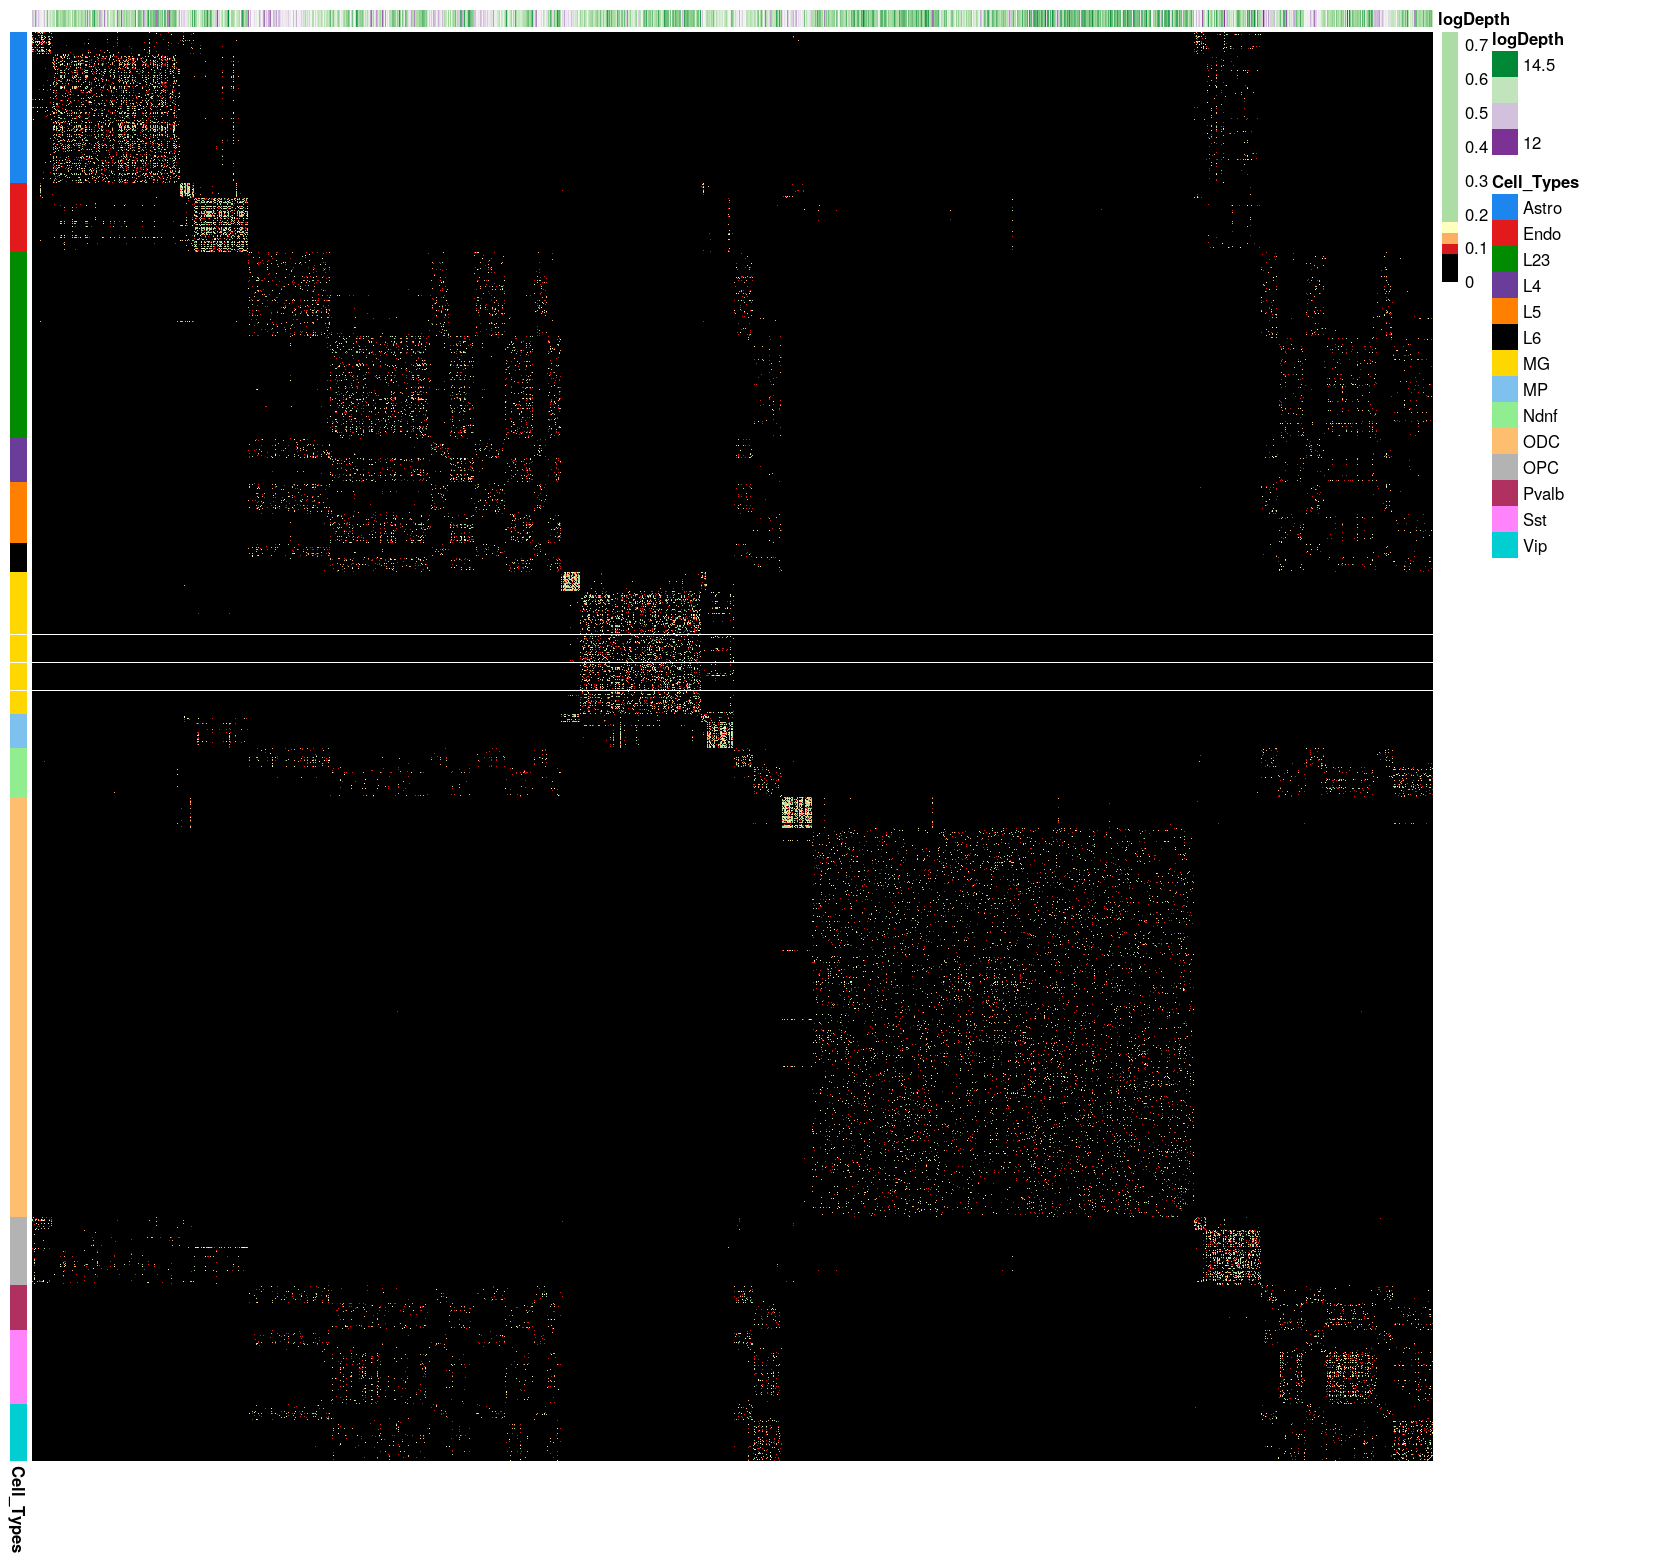

In [44]:
embeddings = fread("/p/keles/schic/volumeA/Ecker2019/human/ecker_tsne_mean/ecker_raw.csv")
G = mlgFindNeighbors(as.matrix(embeddings[, 1:20]))
G = as.matrix(G)
diag(G) = 0
mat_breaks <- quantile_breaks(G, n = 9)
ecker_order = fread("/p/keles/schic/volumeA/Ecker2019/human/cell_order_iceoe.csv")[-1, -1]$V2
sums = fread("/p/keles/schic/volumeA/Ecker2019/human/Ecker2019_summary.txt")
sums = sums[match(ecker_order, sums$name), ]
sums$cell_type = as.factor(sums$cell_type)

depth = data.frame(logDepth = log(sums$depth))
levels(sums$cell_type) = c("Astro", "Endo", "L23", "L4", 'L5', 'L6', 'MG', 'MP', 'Ndnf',
                           'ODC', 'OPC', 'Pvalb', 'Sst', 'Vip')
cell_type = data.frame(Cell_Types = as.factor(sums$cell_type))
rownames(cell_type) = ecker_order
rownames(depth) = ecker_order
rownames(G) = ecker_order
colnames(G) = ecker_order

pheatmap(G, cluster_rows = FALSE, breaks = mat_breaks, color = c("black", brewer.pal(length(mat_breaks) - 1, "Spectral")), annotation_colors = list(Cell_Types = cols, logDepth = brewer.pal(5, "PRGn")), cluster_cols = FALSE, annotation_row = cell_type, annotation_col = depth, show_rownames = FALSE,
        show_colnames = FALSE)
adjustedRandIndex(kmeans(as.matrix(embeddings[, 1:20]), centers = 14, nstart = 20)$cluster, summary$cell_type)

In [26]:
path = "/p/keles/schic/volumeA/Ecker2019/human/Counts_1mb_schic/"
setwd(path)
cell_types = list.files()
cell_type_folders = list.files()
cell_type_folders = paste(path, cell_type_folders, sep = "")
num_types = length(cell_type_folders)

cell_folders = c()
clusters = c()
cell_names = c()
for (i in 1:num_types){
  path = list.files(cell_type_folders[i])
  cell_names = c(cell_names, path)
  path = paste(cell_type_folders[i], "/", path, sep = "")
  cell_folders = c(cell_folders, path)
  clusters = c(clusters, rep(cell_types[i], length(path)))
}

new_batch = substr(cell_names, 1, 11)
out = data.frame(cell_names, batch = new_batch)

[1] 0.565987

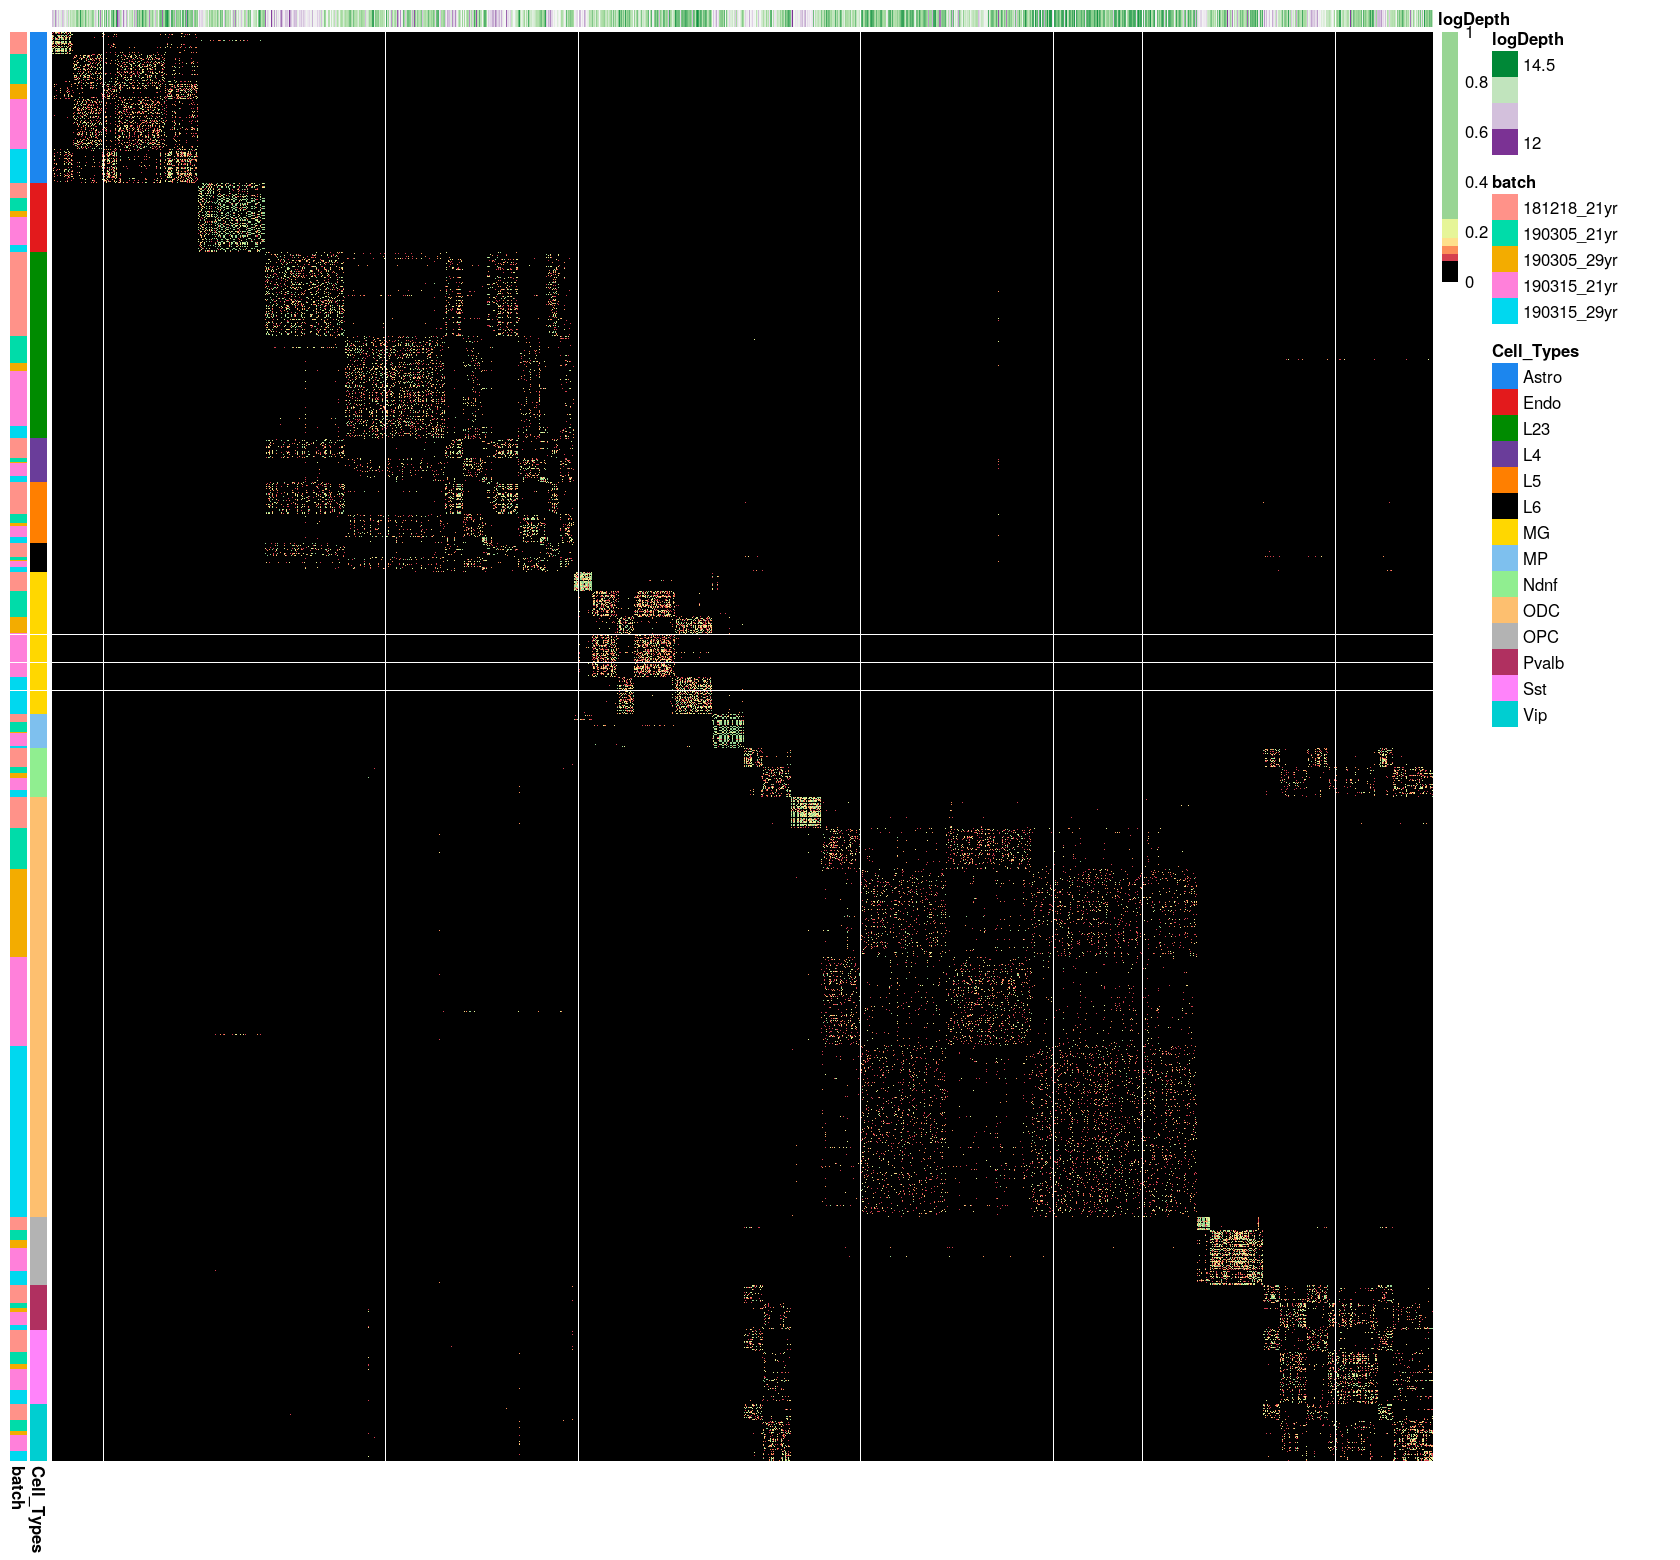

In [27]:
embeddings = fread("/p/keles/schic/volumeA/Script/SNN_heatmap/data/ecker.csv")
G = mlgFindNeighbors(as.matrix(embeddings[, 1:20]))
G = as.matrix(G)
diag(G) = 0
mat_breaks <- quantile_breaks(G, n = 9)
ecker_order = fread("/p/keles/schic/volumeA/Ecker2019/human/cell_order_iceoe.csv")[-1, -1]$V2
sums = fread("/p/keles/schic/volumeA/Ecker2019/human/Ecker2019_summary.txt")
sums = sums[match(ecker_order, sums$name), ]
sums$cell_type = as.factor(sums$cell_type)
out = out[match(ecker_order, out$cell_names), ]
depth = data.frame(logDepth = log(sums$depth))
levels(sums$cell_type) = c("Astro", "Endo", "L23", "L4", 'L5', 'L6', 'MG', 'MP', 'Ndnf',
                           'ODC', 'OPC', 'Pvalb', 'Sst', 'Vip')
cell_type = data.frame(Cell_Types = as.factor(sums$cell_type), batch = out$batch)
rownames(cell_type) = ecker_order
rownames(depth) = ecker_order
rownames(G) = ecker_order
colnames(G) = ecker_order

pheatmap(G, cluster_rows = FALSE, breaks = mat_breaks,color = c("black", brewer.pal(length(mat_breaks) - 1, "Spectral")),  annotation_colors = list(Cell_Types = cols, logDepth = brewer.pal(5, "PRGn")), cluster_cols = FALSE, annotation_row = cell_type, annotation_col = depth, show_rownames = FALSE,
        show_colnames = FALSE)

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations



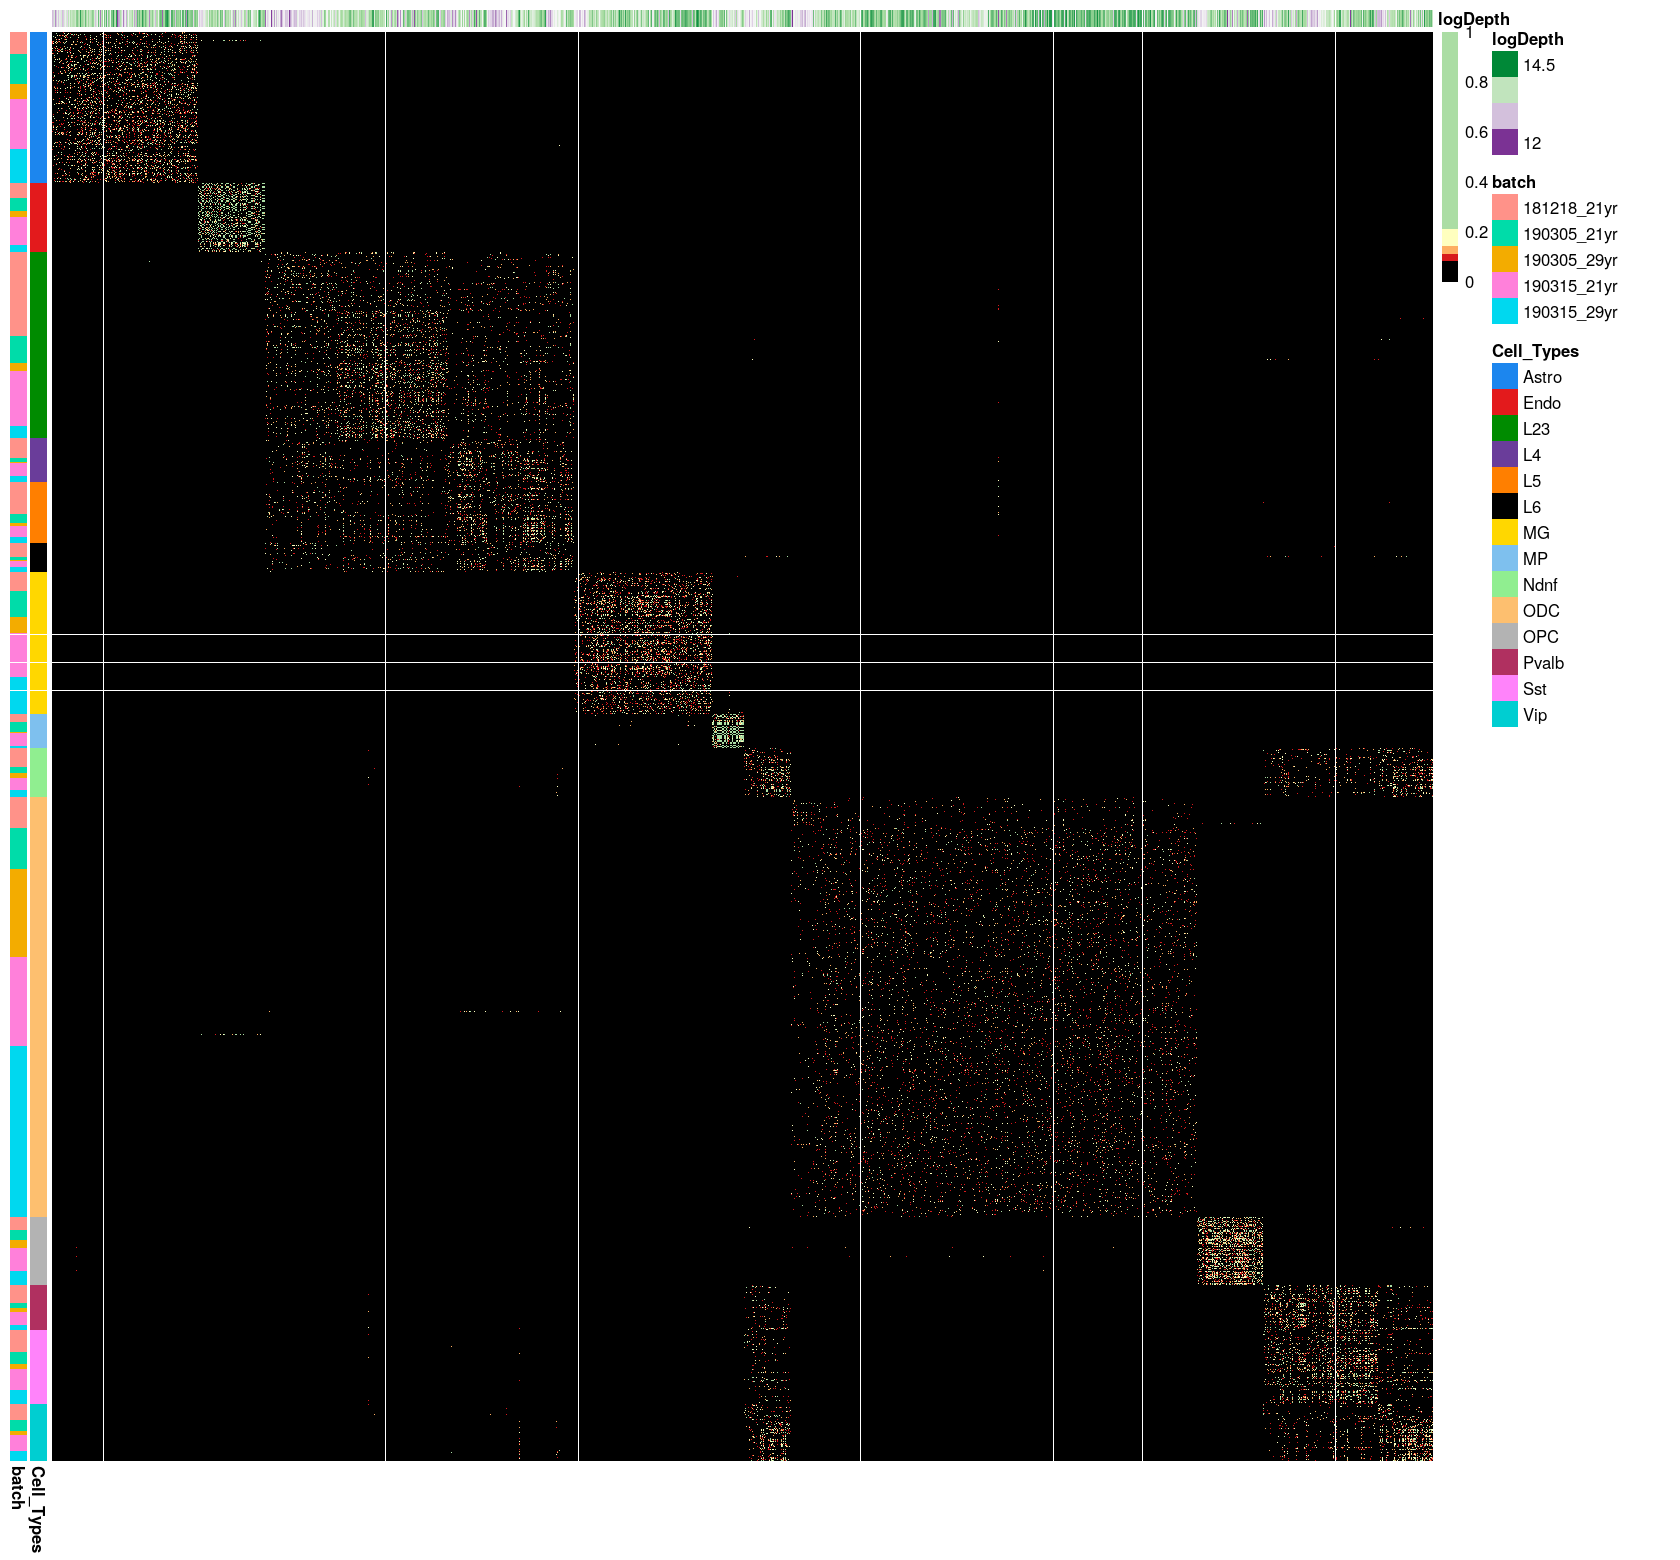

In [11]:
embeddings = fread("/p/keles/schic/volumeA/Script/SNN_heatmap/data/ecker.csv")
embeddings = as.matrix(embeddings)
ecker_order = fread("/p/keles/schic/volumeA/Ecker2019/human/cell_order_iceoe.csv")[-1, -1]$V2
sums = fread("/p/keles/schic/volumeA/Ecker2019/human/Ecker2019_summary.txt")
sums = sums[match(ecker_order, sums$name), ]
sums$cell_type = as.factor(sums$cell_type)
depth = data.frame(logDepth = log(sums$depth))
my_harmony_embeddings <- HarmonyMatrix(t(embeddings), sums$batch, "dataset", do_pca = FALSE)
G = mlgFindNeighbors(t(my_harmony_embeddings)[, 1:20])
G = as.matrix(G)
diag(G) = 0
mat_breaks <- quantile_breaks(G, n = 9)

levels(sums$cell_type) = c("Astro", "Endo", "L23", "L4", 'L5', 'L6', 'MG', 'MP', 'Ndnf',
                           'ODC', 'OPC', 'Pvalb', 'Sst', 'Vip')
cell_type = data.frame(Cell_Types = as.factor(sums$cell_type), batch = sums$batch)
rownames(cell_type) = ecker_order
rownames(depth) = ecker_order
rownames(G) = ecker_order
colnames(G) = ecker_order

pheatmap(G, cluster_rows = FALSE, breaks = mat_breaks,color = c("black", brewer.pal(length(mat_breaks) - 1, "Spectral")),  annotation_colors = list(Cell_Types = cols, logDepth = brewer.pal(5, "PRGn")), cluster_cols = FALSE, annotation_row = cell_type, annotation_col = depth, show_rownames = FALSE,
        show_colnames = FALSE)

[1] 0.4284109

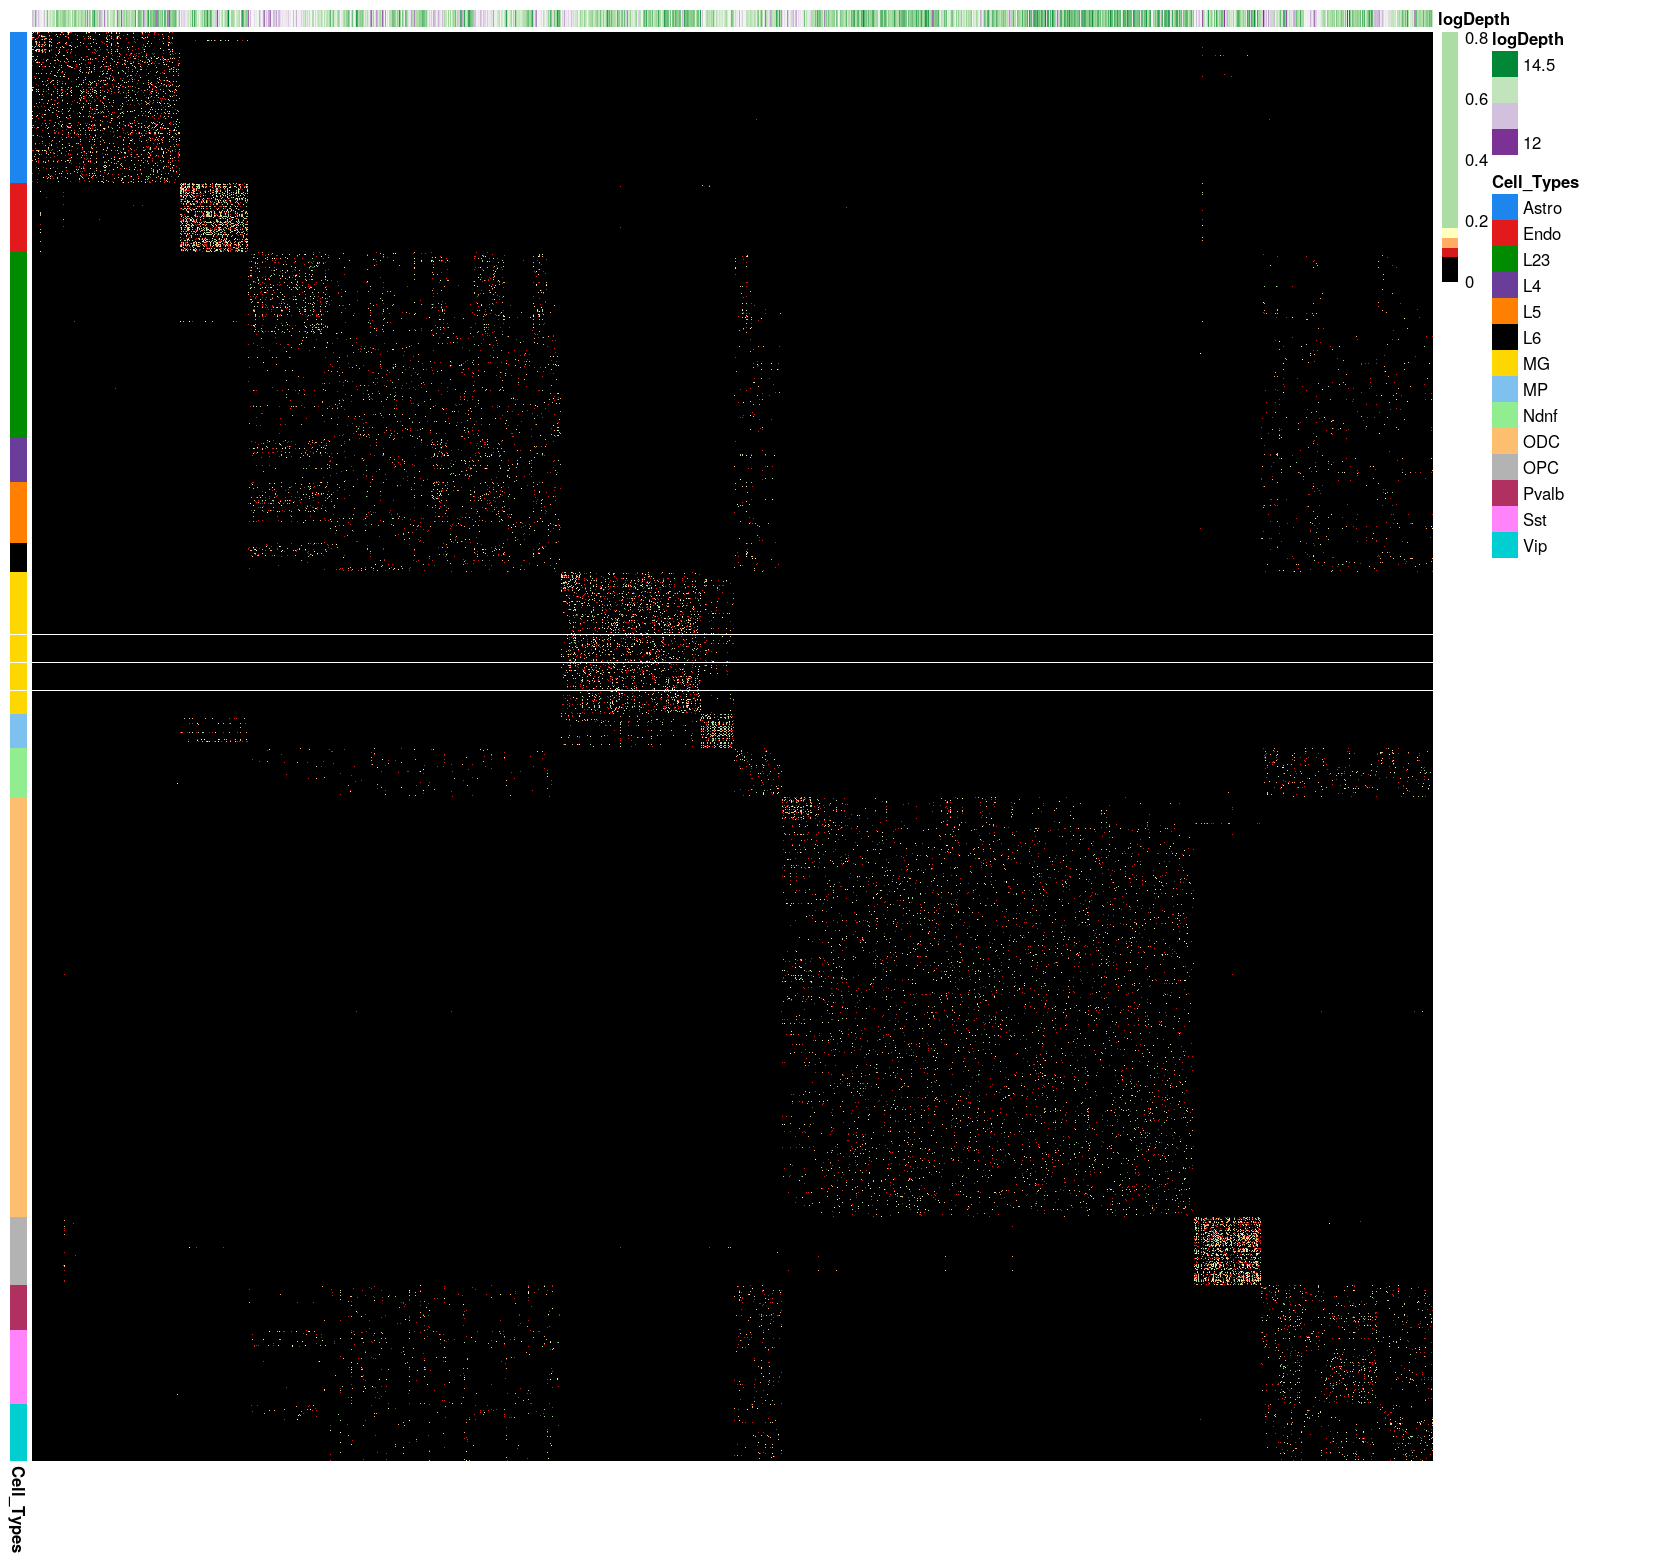

In [48]:
path = paste("/p/keles/schic/volumeA/Ecker2019/human/schicluster/latent_", chr_order, ".csv", sep = "")
embeddings = c()
for (i in 1:23){
    embeddings = cbind(embeddings, fread(path[i]))
}
embeddings = prcomp(embeddings)$x
G = mlgFindNeighbors(as.matrix(embeddings[, 1:20]))
G = as.matrix(G)
diag(G) = 0
mat_breaks <- quantile_breaks(G, n = 9)
ecker_order = fread("/p/keles/schic/volumeA/Ecker2019/human/cell_order_iceoe.csv")[-1, -1]$V2
sums = fread("/p/keles/schic/volumeA/Ecker2019/human/Ecker2019_summary.txt")
sums = sums[match(ecker_order, sums$name), ]
sums$cell_type = as.factor(sums$cell_type)

depth = data.frame(logDepth = log(sums$depth))
levels(sums$cell_type) = c("Astro", "Endo", "L23", "L4", 'L5', 'L6', 'MG', 'MP', 'Ndnf',
                           'ODC', 'OPC', 'Pvalb', 'Sst', 'Vip')
cell_type = data.frame(Cell_Types = as.factor(sums$cell_type))
rownames(cell_type) = ecker_order
rownames(depth) = ecker_order
rownames(G) = ecker_order
colnames(G) = ecker_order

pheatmap(G, cluster_rows = FALSE, breaks = mat_breaks, color = c("black", brewer.pal(length(mat_breaks) - 1, "Spectral")), annotation_colors = list(Cell_Types = cols, logDepth = brewer.pal(5, "PRGn")), cluster_cols = FALSE, annotation_row = cell_type, annotation_col = depth, show_rownames = FALSE,
        show_colnames = FALSE)

[1] 0.4846088

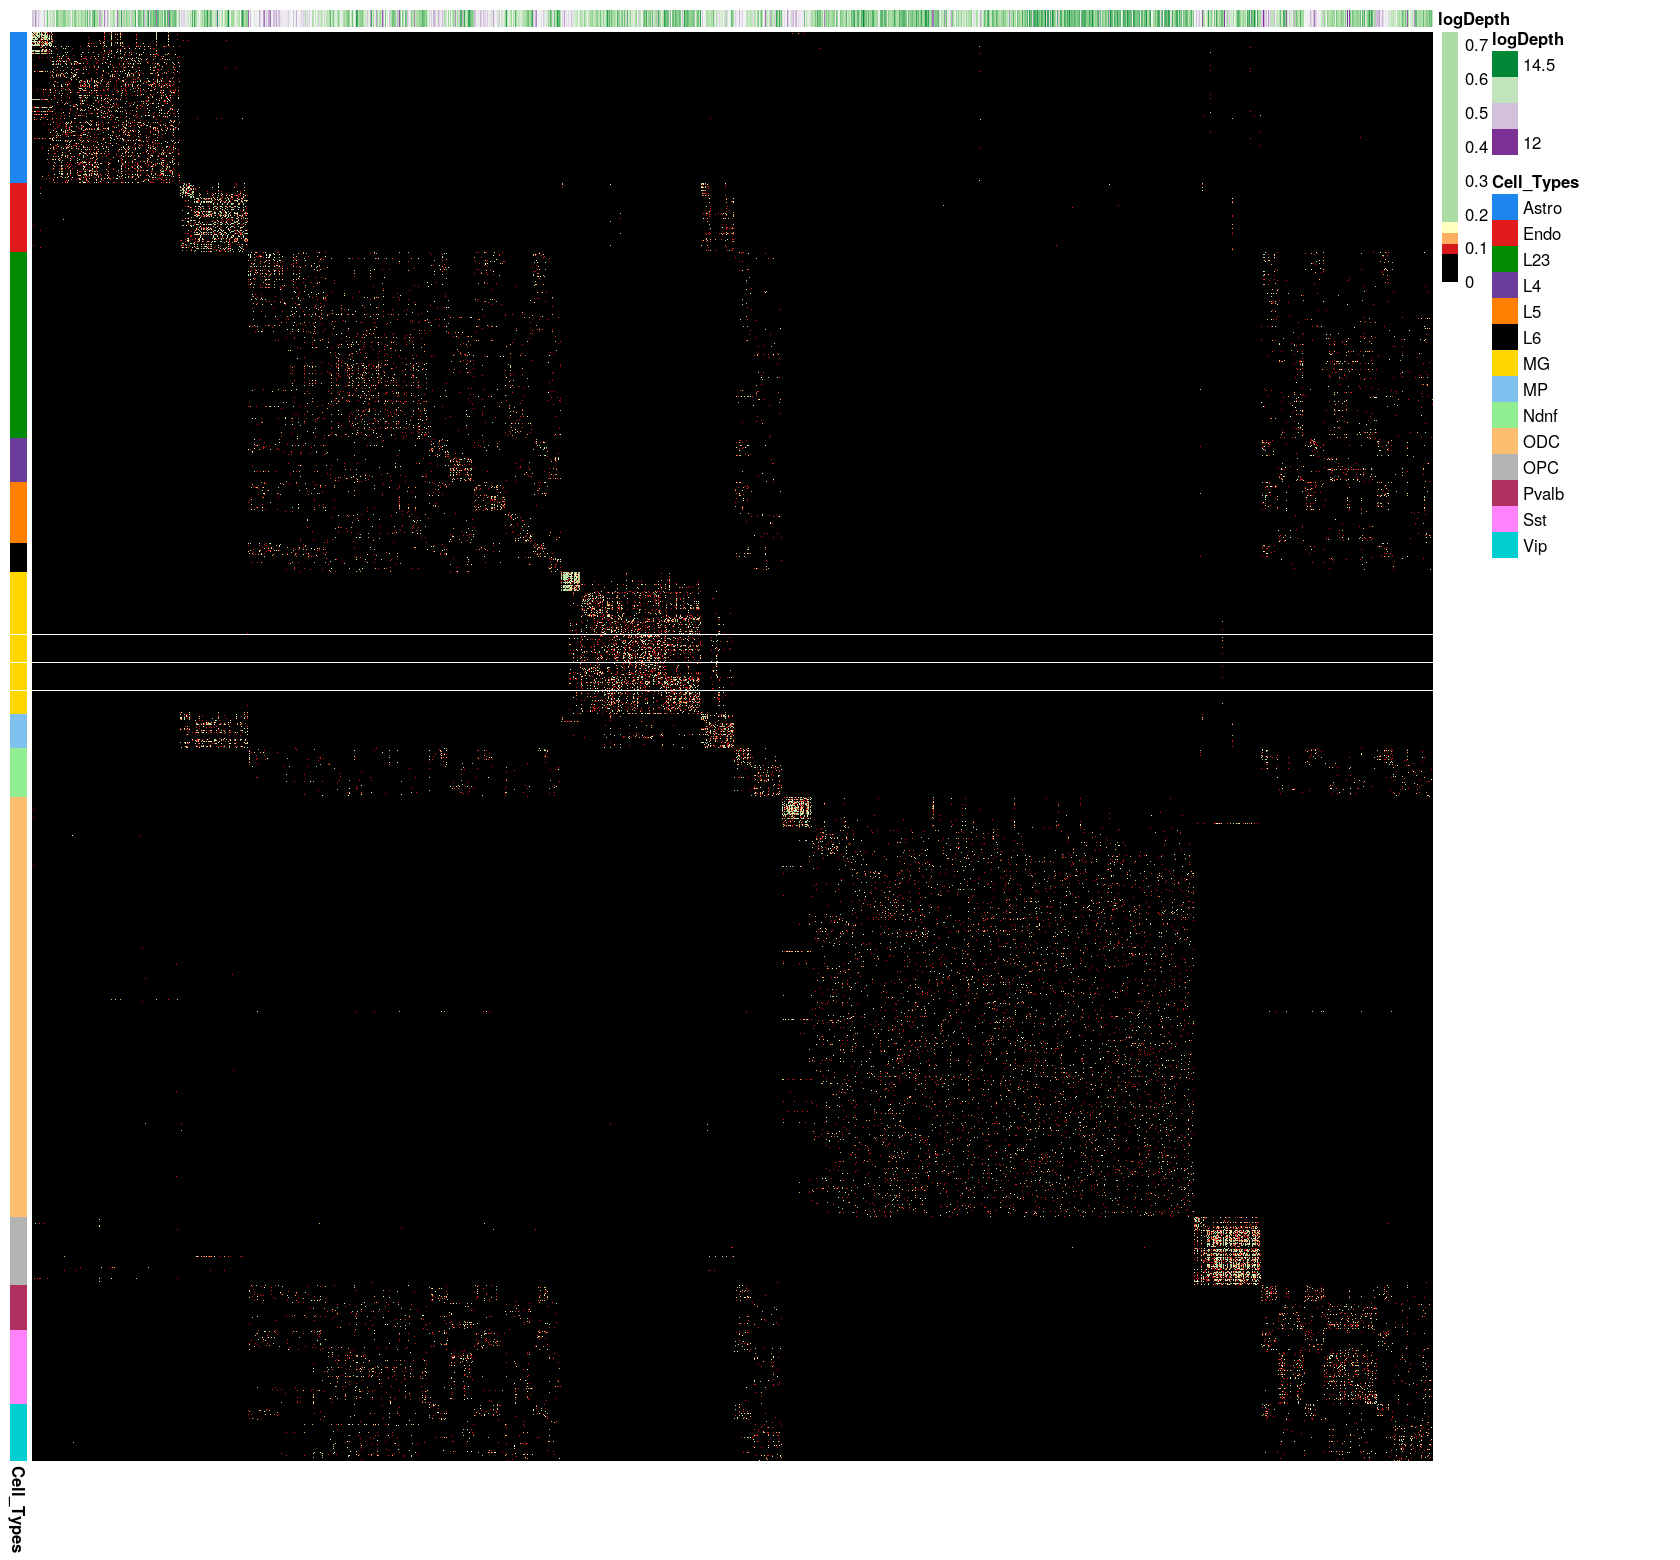

In [49]:
path = paste("/p/keles/schic/volumeA/Ecker2019/human/cvae_output_iceoe/latent_", chr_order, ".csv", sep = "")
embeddings = c()
for (i in 1:23){
    embeddings = cbind(embeddings, fread(path[i]))
}
embeddings = prcomp(embeddings)$x
G = mlgFindNeighbors(as.matrix(embeddings[, 1:20]))
G = as.matrix(G)
diag(G) = 0
mat_breaks <- quantile_breaks(G, n = 9)
ecker_order = fread("/p/keles/schic/volumeA/Ecker2019/human/cell_order_iceoe.csv")[-1, -1]$V2
sums = fread("/p/keles/schic/volumeA/Ecker2019/human/Ecker2019_summary.txt")
sums = sums[match(ecker_order, sums$name), ]
sums$cell_type = as.factor(sums$cell_type)

depth = data.frame(logDepth = log(sums$depth))
levels(sums$cell_type) = c("Astro", "Endo", "L23", "L4", 'L5', 'L6', 'MG', 'MP', 'Ndnf',
                           'ODC', 'OPC', 'Pvalb', 'Sst', 'Vip')
cell_type = data.frame(Cell_Types = as.factor(sums$cell_type))
rownames(cell_type) = ecker_order
rownames(depth) = ecker_order
rownames(G) = ecker_order
colnames(G) = ecker_order

pheatmap(G, cluster_rows = FALSE, breaks = mat_breaks, color = c("black", brewer.pal(length(mat_breaks) - 1, "Spectral")), annotation_colors = list(Cell_Types = cols, logDepth = brewer.pal(5, "PRGn")), cluster_cols = FALSE, annotation_row = cell_type, annotation_col = depth, show_rownames = FALSE,
        show_colnames = FALSE)

In [62]:
embeddings = fread("/p/keles/schic/volumeA/Script/SNN_heatmap/data/ecker_higashi.csv")[-1, -1]
embeddings = prcomp(embeddings)$x
G = mlgFindNeighbors(as.matrix(embeddings[, 1:20]))
G = as.matrix(G)
diag(G) = 0
mat_breaks <- quantile_breaks(G, n = 9)
sums = fread("/p/keles/schic/volumeA/Ecker2019/human/Ecker2019_summary.txt")
sums$cell_type = as.factor(sums$cell_type)

depth = data.frame(logDepth = log(sums$depth))
levels(sums$cell_type) = c("Astro", "Endo", "L23", "L4", 'L5', 'L6', 'MG', 'MP', 'Ndnf',
                           'ODC', 'OPC', 'Pvalb', 'Sst', 'Vip')
cell_type = data.frame(Cell_Types = as.factor(sums$cell_type))
rownames(cell_type) = ecker_order
rownames(depth) = ecker_order
rownames(G) = ecker_order
colnames(G) = ecker_order

pheatmap(G, cluster_rows = FALSE, breaks = mat_breaks, color = c("black", brewer.pal(length(mat_breaks) - 1, "Spectral")), annotation_colors = list(Cell_Types = cols, logDepth = brewer.pal(5, "PRGn")), cluster_cols = FALSE, annotation_row = cell_type, annotation_col = depth, show_rownames = FALSE,
        show_colnames = FALSE)

ERROR: Error in convert_annotations(annotation_row, annotation_colors): Factor levels on variable Cell_Types do not match with annotation_colors


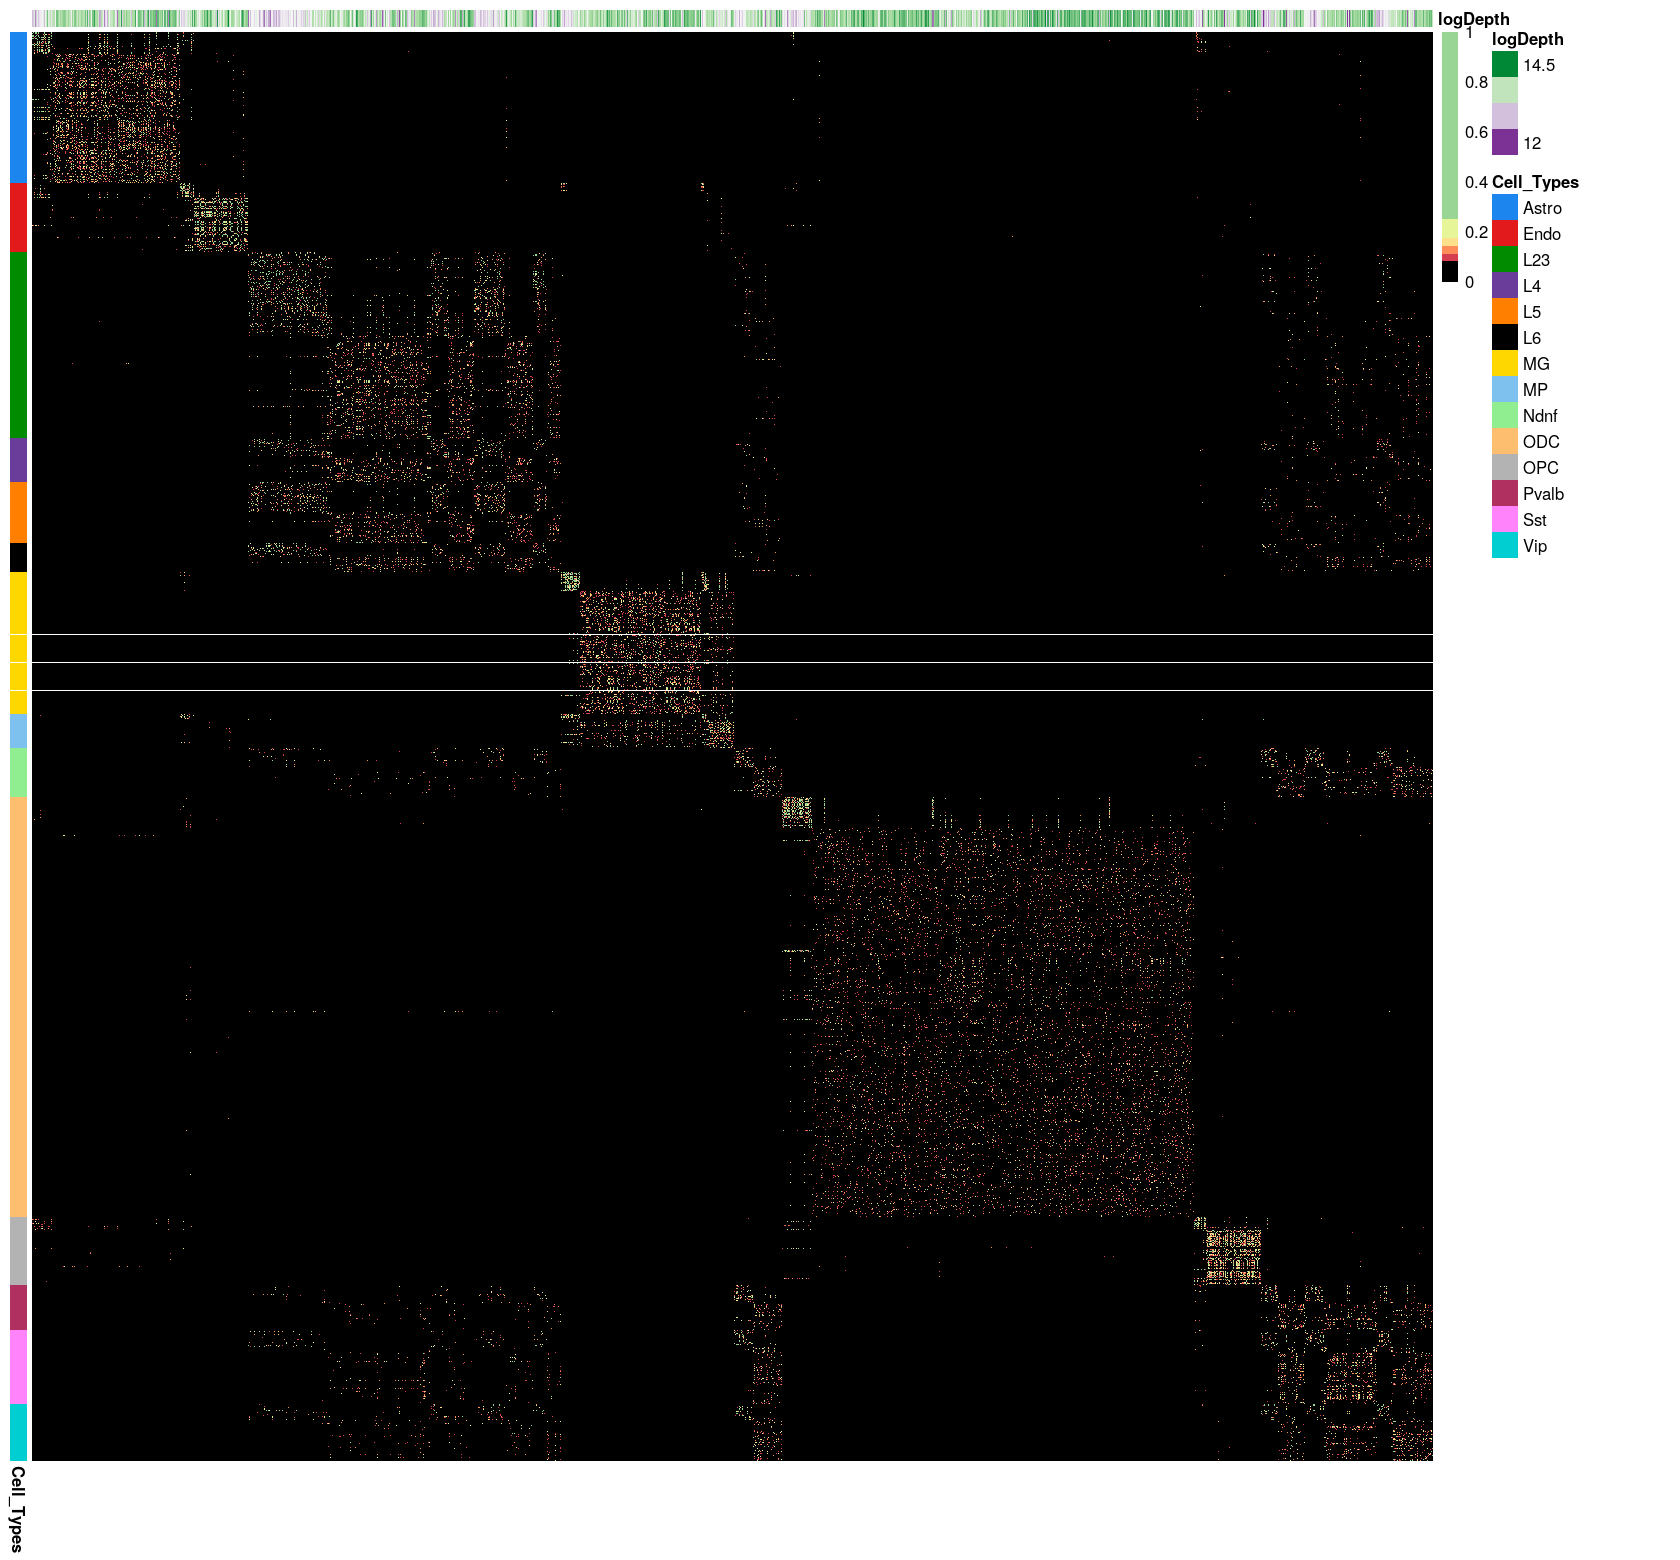

In [16]:
embeddings = fread("/p/keles/schic/volumeA/Script/SNN_heatmap/data/ecker_cis.csv")[, -1]

ecker_order = fread("/p/keles/schic/volumeA/Script/SNN_heatmap/data/ecker_order.csv")[-1, -1]$V2

sums = fread("/p/keles/schic/volumeA/Ecker2019/human/Ecker2019_summary.txt")
sums = sums[match(ecker_order, sums$name), ]
sums$cell_type = as.factor(sums$cell_type)
levels(sums$cell_type) = c("Astro", "Endo", "L23", "L4", 'L5', 'L6', 'MG', 'MP', 'Ndnf',
                           'ODC', 'OPC', 'Pvalb', 'Sst', 'Vip')

embeddings = prcomp(embeddings)$x
G = mlgFindNeighbors(as.matrix(embeddings[, 1:20]))
G = as.matrix(G)
diag(G) = 0
mat_breaks <- quantile_breaks(G, n = 9)
rownames(cell_type) = ecker_order
rownames(depth) = ecker_order
rownames(G) = sums$name
colnames(G) = sums$name
cell_type = data.frame(Cell_Types = as.factor(sums$cell_type))
depth = data.frame(logDepth = log(sums$depth))

rownames(cell_type) = sums$name
rownames(depth) = sums$name

pheatmap(G, cluster_rows = FALSE, breaks = mat_breaks, color = c("black", brewer.pal(length(mat_breaks) - 1, "Spectral")), annotation_colors = list(Cell_Types = cols, logDepth = brewer.pal(5, "PRGn")), cluster_cols = FALSE, annotation_row = cell_type, annotation_col = depth, show_rownames = FALSE,
        show_colnames = FALSE)